# Сегментация дефектов кожного покрова


In [1]:
 #набор данных isic

In [2]:
#%%capture
# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip ISIC2018

# !unzip -q ISIC2018_Task1-2_Training_Input.zip
# !rm ISIC2018_Task1-2_Training_Input.zip

# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip ISIC2018

# !unzip -q ISIC2018_Task1_Training_GroundTruth.zip
# !rm ISIC2018_Task1_Training_GroundTruth.zip

# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip ISIC2018
# !unzip ISIC2018_Task1-2_Validation_Input.zip
# !rm ISIC2018_Task1-2_Validation_Input.zip

# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip ISIC2018
# !unzip ISIC2018_Task1_Validation_GroundTruth.zip
# !rm ISIC2018_Task1_Validation_GroundTruth.zip

# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Test_Input.zip ISIC2018
# !unzip ISIC2018_Task1-2_Test_Input.zip
# !rm ISIC2018_Task1-2_Test_Input.zip

# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Test_GroundTruth.zip ISIC2018
# !unzip ISIC2018_Task1_Test_GroundTruth.zip
# !rm ISIC2018_Task1_Test_GroundTruth.zip

In [3]:
# !rm ISIC2018_Task1-2_Training_Input/LICENSE.txt
# !rm ISIC2018_Task1-2_Training_Input/ATTRIBUTION.txt

In [4]:
# !rm ISIC2018_Task1-2_Validation_Input/LICENSE.txt
# !rm ISIC2018_Task1-2_Validation_Input/ATTRIBUTION.txt

In [5]:
# !rm ISIC2018_Task1-2_Test_Input/LICENSE.txt
# !rm ISIC2018_Task1-2_Test_Input/ATTRIBUTION.txt

In [6]:
# !rm ISIC2018_Task1_Training_GroundTruth/ATTRIBUTION.txt
# !rm ISIC2018_Task1_Training_GroundTruth/LICENSE.txt

In [7]:
# !rm ISIC2018_Task1_Validation_GroundTruth/ATTRIBUTION.txt
# !rm ISIC2018_Task1_Validation_GroundTruth/LICENSE.txt

In [8]:
# !rm ISIC2018_Task1_Test_GroundTruth/ATTRIBUTION.txt
# !rm ISIC2018_Task1_Test_GroundTruth/LICENSE.txt

In [9]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.image_files = os.listdir(image_folder)
        self.mask_files = os.listdir(mask_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        mask_path = os.path.join(self.mask_folder, mask_name)
        
        image = Image.open(img_path)
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) #не нужно Normalize

        return image, mask


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size of ResNet-50
    transforms.ToTensor(),  # Convert PIL image to tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

In [12]:
train_dataset = CustomDataset(image_folder='ISIC2018_Task1-2_Training_Input/', mask_folder='ISIC2018_Task1_Training_GroundTruth/', transform=transform)
val_dataset = CustomDataset(image_folder='ISIC2018_Task1-2_Validation_Input/', mask_folder='ISIC2018_Task1_Validation_GroundTruth/', transform=transform)
test_dataset = CustomDataset(image_folder='ISIC2018_Task1-2_Test_Input/', mask_folder='ISIC2018_Task1_Test_GroundTruth/', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
len(train_dataset)

2594

In [14]:
import wandb
wandb.login()
wandb.init(
    project="skin-defects-segmentation",
    name='segnet-1-15',
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 1e-3,
        "epochs": 2,
    })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ar4ikov (socialcode_donstu). Use `wandb login --relogin` to force relogin


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchvision import transforms
from scipy.ndimage import distance_transform_edt as dist
from pandas import DataFrame  as df
from pandas import Series
from pandas import read_csv
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

!nvidia-smi

torch.cuda.is_available()

Thu May 25 00:36:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:24:00.0 Off |                  N/A |
|  0%   38C    P8               22W / 350W|    736MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [16]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1,'

In [17]:
class SegNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, padding=1, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)# 128 -> 64
                                       

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, padding=1, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
                                      
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, padding=1, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)      # 32 -> 16
                                       
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, padding=1, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool4 = nn.MaxPool2d(kernel_size=2, return_indices=True) 
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, padding=1, kernel_size=3),
            nn.BatchNorm2d(256)
        )
        
        # decoder (upsampling)
        #self.upsample0  # 16 -> 32
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        #self.upsample1 =  # 32 -> 64
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
       # self.upsample2 =   # 64 -> 128
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
       # self.upsample3 =   # 128 -> 256
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(8, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        # encoder
        e0, i4 = self.pool0(self.enc_conv0(x))     
        e1, i3 = self.pool1(self.enc_conv1(e0))
        e2, i2 = self.pool2(self.enc_conv2(e1))
        e3, i1 = self.pool3(self.enc_conv3(e2))
        e4, i0 = self.pool4(self.enc_conv4(e3))
        # bottleneck
        b = self.bottleneck_conv(e4)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,i0))
        d1 = self.dec_conv1(self.upsample1(d0,i1))
        d2 = self.dec_conv2(self.upsample2(d1,i2))
        d3 = self.dec_conv3(self.upsample3(d2,i3))
        d4 = self.dec_conv4(self.upsample4(d3,i4))
         # no activation
        return d4

In [18]:
def iou_pytorch(outputs: torch.Tensor, masks: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(0).byte()  # BATCH x 1 x H x W => BATCH x H x W
    masks = masks.squeeze(0).byte()
    SMOOTH = 1e-8
    intersection = (outputs & masks).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | masks).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou.mean() #thresholded  # 

In [19]:
def bce_loss(y_real, y_pred):
    a=y_pred-y_pred * y_real + torch.log(1 + torch.exp(-y_pred))
    a=a.mean()  # TODO 
    return a  # please don't use nn.BCELoss. write it from scratch

In [20]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, data_ts, lr_scheduler=None):
    train_losses = []
    val_losses = []

    accuracy_train = []
    accuracy_val = []
    
    for epoch in range(epochs):
        train_loss_epoch = 0
        validation_loss_epoch = 0
        
        train_scores = 0
        val_scores = 0
        
        tic = time()
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_loss = 0

        model.train()  # train mode
        
        for X_train, Y_train in tqdm(data_tr):
            X_train, Y_train = X_train.to(device), Y_train.to(device) # data to device

            # set parameter gradients to zero
            opt.zero_grad()
            
            # forward
            Y_pred = model(X_train)

            loss = loss_fn(Y_train, Y_pred) # forward-pass
            
            loss.backward()  # backward-pass
            opt.step()  # update weights
            
            train_loss_epoch += loss.item()
            
            # log to wandb
            wandb.log({"train_loss": loss})
            
            # calc accuracy
            train_scores += iou_pytorch(Y_pred > 0.5, Y_train).mean().item()
        
        toc = time()
        
        # show intermediate results
        model.eval()  # testing mode
        
        for X_val, Y_val in tqdm(data_val):
            X_val, Y_val = X_val.to(device), Y_val.to(device)

            with torch.no_grad():    
                Y_hat = model(X_val.to(device))
            
            vall_loss = loss_fn(Y_val, Y_hat)
            
            validation_loss_epoch += loss.item()
            
            # calc accuracy
            val_scores += iou_pytorch(Y_hat > 0.5, Y_val).mean().item()
        
        # reduce learning rate if lr_scheduler is not None
        if lr_scheduler is not None:
            lr_scheduler.step()
            
        # calc loss per epoch
        train_loss = train_loss_epoch / len(data_tr)
        val_loss = validation_loss_epoch / len(data_val)
        
        # add to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # log loss to wandb
        wandb.log({"val_loss": val_loss})

        acc_train_epoch = train_scores / len(data_tr)
        acc_val_epoch = val_scores / len(data_val)
        
        # add accuracy to lists
        accuracy_train.append(acc_train_epoch)
        accuracy_val.append(acc_val_epoch)
        
        wandb.log({"train_acc": acc_train_epoch})
        wandb.log({"val_acc": acc_val_epoch})
        
        # Visualize tools
        clear_output(wait=True)
            
        X_val, Y_val = next(iter(data_val))
        X_val, Y_val = X_val.to(device), Y_val.to(device)

        with torch.no_grad():
            Y_hat = model(X_val)
        
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(Y_val.cpu().detach()[k, 0], cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat.cpu().detach()[k, 0]>0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat.cpu().detach()[k, 0], cmap='gray') 
            plt.title('Output2')
            plt.axis('off')
        
        plt.suptitle('%d / %d - loss_train: %f || loss_val: %f || acc_train_epoch: %f || acc_val_epoch: %f' % (
            epoch + 1, epochs, train_loss, val_loss, acc_train_epoch, acc_val_epoch)
        )
        
        # save plot visualization
        plt.savefig(f"output_{epoch + 1}.png")
        
    # test model
    X_test, Y_test = next(iter(data_ts))
    X_test, Y_test = X_test.to(device), Y_test.to(device)

    with torch.no_grad():
        Y_hat = model(X_test)
        
    # visualize test data
    test(model, X_test, Y_hat)
                
    return accuracy_test, accuracy_val

In [21]:
m, n = next(iter(test_loader))

In [30]:
def test(model, y_true, y_pred):   
    for k in range(6):
        plt.subplot(3, 6, k + 1)
        plt.imshow(y_true.cpu().detach()[k][0], cmap='gray')

        plt.subplot(3, 6, k + 7)
        plt.imshow(y_pred.cpu().detach()[k][0], cmap='gray')

        plt.subplot(3, 6, k + 13)
        plt.imshow(y_pred.cpu().detach()[k][0] > 0.5, cmap='gray')
        
    plt.savefig("output_test.png")

In [23]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [24]:
model = SegNet2().to(device)

In [ ]:
max_epochs = 15
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt,gamma=0.95)
Segnet_BCE_test_acc, Segnet_BCE_val_acc = train(model, opt, bce_loss, max_epochs, train_loader, val_loader, test_loader, lr_scheduler)

In [ ]:
# save the model
torch.save(model, 'segnet-1-15.pth')

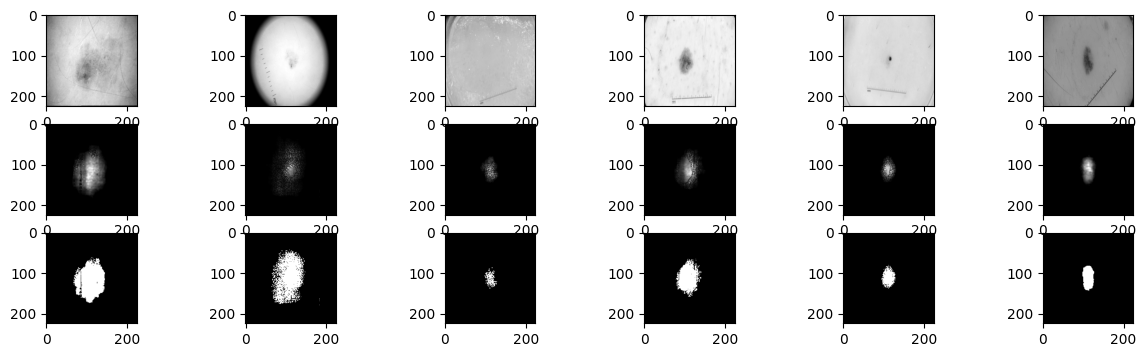

In [31]:
# for the test
X_test, Y_test = next(iter(test_loader))
X_test, Y_test = X_test.to(device), Y_test.to(device)

with torch.no_grad():
    Y_hat = model(X_test)
        
# visualize test data
test(model, X_test, Y_hat)